##### 1. digit recognizer

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as skl

In [2]:
data = np.loadtxt("train.csv", delimiter = ",", skiprows = 1)

In [3]:
y = data[:,0] #digits, take the first column
X = data[:,1:] #pixels, take everything but the 1st column

### (b) Write a function to display an MNIST digit. Display one of each digit.

In [7]:
##function to display only one row
def displayDigit(data, row):
    y = data[:,0] #digits
    X = data[:,1:].astype(int) #pixels
    plt.imshow(X[row].reshape((28,28)), cmap=plt.get_cmap('gray'))

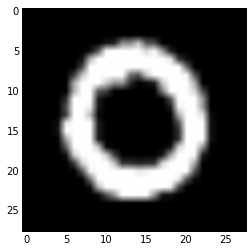

In [8]:
displayDigit(data, 1)

In [8]:
def displayTenDigits(X, y, unique_digit_index):
    fig = plt.figure()
    for idx, ud in enumerate(unique_digit_index):
        ax = fig.add_subplot(2, 5, idx + 1)
        ax.imshow(X[ud].reshape((28,28)),  cmap=plt.get_cmap('gray'))


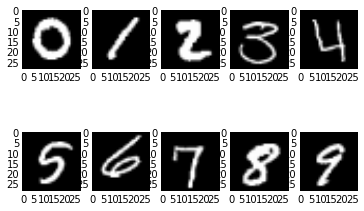

In [9]:
_, unique_digit_index = np.unique(y, return_index = True)
displayTenDigits(X, y, unique_digit_index)
plt.savefig("10_digits.png")


### (c) Examine the prior probability of the classes in the training data. Is it uniform across the digits? Display a normalized histogram of digit counts. Is it even? mostly uniform across digits, mostly even.

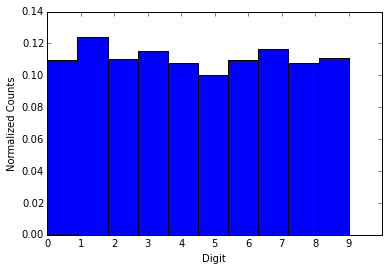

In [10]:
plt.hist(y, normed=1)
plt.xlabel("Digit")
plt.ylabel("Normalized Counts")
set_x = [i for i in xrange(0,10)]
plt.gca().set_xticks(set_x, minor=False)
plt.savefig('histogram_digitcounts.png')

### (d) Pick one example of each digit from your training data. Then, for each sample digit,compute and show the best match (nearest neighbor) between your chosen sample and the rest of the training data. Use L2 distance between the two images’ pixel values as the metric. This probably won’t be perfect, so add an asterisk next to the erroneous examples.

In [12]:
minDistList = []
for ud in unique_digit_index:
    nn = np.linalg.norm(X[ud] - X, axis = 1).astype(float)
    nn[nn == 0] = np.Inf
    minDistList.append(np.argmin(nn)) 

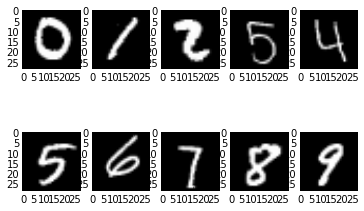

In [16]:
displayTenDigits(X, y, minDistList)
plt.savefig("best_match.png")

### (e) Consider the case of binary comparison between the digits 0 and 1. Ignoring all the other digits, compute the pairwise distances for all genuine matches and all impostor matches, again using the L2 norm. Plot histograms of the genuine and impostor distances on the same set of axes.

In [5]:
from scipy import spatial 
genuine_zero = sp.spatial.distance.cdist(X[y==0], X[y==0], 'euclidean')
genuine_one = sp.spatial.distance.cdist(X[y==1], X[y==1], 'euclidean')
imposter = sp.spatial.distance.cdist(X[y==0], X[y==1], 'euclidean')

In [6]:
#get only upper triangular part
genuine_zero = np.triu(genuine_zero)
genuine_one = np.triu(genuine_one)
imposter = np.triu(imposter)

In [7]:
genuine_zero_flat = genuine_zero.flatten()
genuine_one_flat = genuine_one.flatten()
imposter_flat = imposter.flatten()

In [8]:
# remove 0s from the matrices
genuine_zero_flat = genuine_zero_flat[genuine_zero_flat != 0]
genuine_one_flat = genuine_one_flat[genuine_one_flat !=0]
imposter_flat = imposter_flat[imposter_flat != 0]

In [9]:
all_genuine = np.concatenate((genuine_one_flat, genuine_zero_flat), axis = 0)

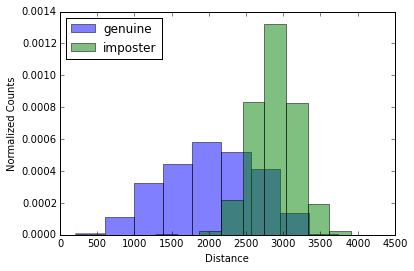

In [10]:
plt.hist(all_genuine, label= 'genuine', alpha=0.5, bins=10, normed=1)
plt.hist(imposter_flat, label = 'imposter', alpha=0.5, bins=10, normed=1)
plt.xlabel("Distance")
plt.ylabel("Normalized Counts")
plt.legend(loc='upper left')
plt.savefig("genimp.png")

### (f) Generate an ROC curve from the above sets of distances. What is the equal error rate? What is the error rate of a classifier that simply guesses randomly?


In [11]:
tpr = []
fpr = []
for t in range(0, int(max(imposter_flat)), 10):
    tpr.append(np.where(all_genuine < t)[0].shape[0] / float(all_genuine.shape[0]))
    fpr.append(np.where(imposter_flat < t)[0].shape[0] / float(imposter_flat.shape[0]))

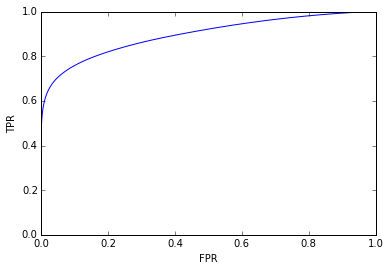

In [12]:
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.savefig("ROC_curve.png")

In [49]:
# area under curve, or equal error rate
skl.metrics.auc(fpr, tpr)

0.89544024461374216

### g)Implement a K-NN classifier. 

In [56]:
#Find k nearest neighbors:
#1. calculate distance matrix between each X_test and  all X_train
#2. each entry in a row of the distance matrix will represents the distance between X_test for that row, 
#   and all images in X_train
#3. sort each row of the distance matrix, and store it in sorted rows, also saving the index from 0:len(X_train)
#4. we pick the k smallest distances in each row to represent the k nearest neighbors from X_train to X_test
#5. we store the indices in array kNN
#5. return array of kNN

def kNN(testing_indices, training_indices, k):
    kNN = []
    dist = sp.spatial.distance.cdist(X[testing_indices], X[training_indices], 'euclidean')
    for row in dist:
        sortedrows = sorted(enumerate(row), key = lambda x: x[1])
         #take the k first nearest neighbors
        kNN.append([j[0] for j in sortedrows[:k]])
    return kNN

In [57]:
#classify each row in kNN matrix:
#1. create a predictions array
#2. for each row in kNN matrix, match the k indices with digits in the y_train array and store in temp.
#3. get the "most_common" digit in the temp list and append it to the predictions array.

from collections import Counter
def classify(kNN, training_indices):
    predictions = []
    for r in kNN:
        temp = [y[training_indices][i] for i in r]
        predictions.append(Counter(temp).most_common(1)[0][0])
    return predictions

In [58]:
#compute the accuracy:
#1. input the predictions array, and the actual y_test array
#2. calculate the number of matches in both arrays by summing true booleans
#3. return the number of matching digits

def accuracy(predictions, actual):
    matches = sum(actual == predictions)
    return float(matches)/len(predictions)

### (h) Using the training data for all digits, perform 3 fold cross-validation on your K-NN classifier and report your average accuracy.

In [35]:
from sklearn import cross_validation

In [36]:
kf = cross_validation.KFold(42000, n_folds=3)
test_indices = []
train_indices = []
for train_index, test_index in kf:
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train_indices.append(train_index)
    test_indices.append(test_index)

('TRAIN:', 28000, 'TEST:', 14000)
('TRAIN:', 28000, 'TEST:', 14000)
('TRAIN:', 28000, 'TEST:', 14000)


In [59]:
#this goes through the knearest neighbor implementation for 3 fold cross validation
#gets an accuracy for each trial, and then takes the average of all accuracies.
results = []
def implement(k):
    accuracies = [] 
    for i in xrange(len(kf)):
        kNN = kNearestNeighborEfficient(test_indices[i], train_indices[i], k)
        result = classify(kNN, train_indices[i])
        results.append(result)
        accuracies.append(accuracy(result, y[test_indices[i]]))
    return sum(accuracies)/float(len(accuracies))       

In [38]:
k_3 = implement(3)
# for k = 3, we get an accuracy of 0.9661666666666667

In [60]:
#k = 5, we get an accuracy of 0.9656190476190476
k_5 = implement(5)
k_5

0.9656190476190476

In [61]:
#for k = 4 we get an accuracy of 0.9649047619047618
k_4 = implement(4)
k_4

0.9649047619047618

### (i) Generate a confusion matrix(ofsize10×10)from your results.Which digits are particularly tricky to classify?


In [39]:
def confusion_mtx(prediction, actual):
    confusion_matrix = np.zeros((10,10))
    for num in xrange(10):
        indices = [i for i,x in enumerate(prediction) if x==num] #indices in results[j]
        for a in xrange(10):
            confusion_matrix[num, a] = sum(actual[indices] == a)
    return confusion_matrix

In [ ]:
confusion_matrix = np.zeros((10,10))
for r in xrange(len(results)):
    cm = confusion_mtx(results[r], y[test_indices[r]])
    confusion_matrix += cm

In [ ]:
cm = confusion_matrix / len(y)

In [ ]:
sum(np.diag(cm))

### (j) Train your classifier with all of the training data, and test your classifier with the test data. Submit your results to Kaggle.

In [52]:
def kNN_submission(test_X, train_X, k):
    kNN = []
    dist = sp.spatial.distance.cdist(test_X, train_X, 'euclidean')
    for row in dist:
        sortedrows = sorted(enumerate(row), key = lambda x: x[1])
         #take the first k nearest neighbors
        kNN.append([j[0] for j in sortedrows[:k]])
    return kNN

from collections import Counter
def classify_submission(kNN, train_X, train_y):
    predictions = []
    for r in kNN:
        temp = [train_y[i] for i in r]
        predictions.append(Counter(temp).most_common(1)[0][0])
    return predictions


In [ ]:
#test this on some data first
train_X = X[train_indices[0]]
train_y = y[train_indices[0]]
test_X = X[test_indices[0]]
test_y = y[test_indices[0]]
kNN_test = kNN(test_X, train_X, 3)
classified_test = classify(kNN_test, train_X, train_y)
accuracy(classified_test, test_y)

In [ ]:
test_data = np.loadtxt("test.csv", delimiter = ",", skiprows = 1)

In [ ]:
kNN_sub = kNN(test_data, X, 3)
submission1 = classify(kNN_sub, X, y)

In [ ]:
submission1_copy = np.asarray(submission1)

In [ ]:
submission1_copy = submission1_copy.astype(int)

In [ ]:
submission1_df = pd.DataFrame(submission1_copy ,columns = ['Label'])
submission1_df['ImageId'] = submission1_df.index + 1
cols = submission1_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
submission1_df = submission1_df[cols]

In [ ]:
submission1_df.to_csv("mnist.submission1.csv", index = False)

In [ ]:
# kNN_sub2 = kNN(test_data, X, 5)
# submission2 = classify(kNN_sub2, X, y)